In [1]:
import jieba
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
## 导入torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
## 常用包 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from textwrap import wrap
import re
%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.head(5)

id            level_1  level_2           level_3  \
0   0  工业/危化品类（现场）—2016版  （二）电气安全  6、移动用电产品、电动工具及照明   
1   1  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   
2   2  工业/危化品类（现场）—2016版  （一）消防检查            2、防火检查   
3   3  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   
4   4  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   

                                             level_4  \
0  1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。   
1                           3、消防设施、器材和消防安全标志是否在位、完整；   
2                           6、重点工种人员以及其他员工消防知识的掌握情况；   
3                           3、消防设施、器材和消防安全标志是否在位、完整；   
4                  4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；   

                      content  label  
0  使用移动手动电动工具,外接线绝缘皮破损,应停止使用.      0  
1                          一般      1  
2                     消防知识要加强      0  
3             消防通道有货物摆放 清理不及时      0  
4                     防火门打开状态      0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       12000 non-null  int64 
 1   level_1  12000 non-null  object
 2   level_2  12000 non-null  object
 3   level_3  12000 non-null  object
 4   level_4  12000 non-null  object
 5   content  11998 non-null  object
 6   label    12000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 656.4+ KB


In [5]:
##查看缺失值
train.isnull().sum()
## 填补缺失值 
train['content'] = train['content'].fillna('')

In [6]:
train['label'].value_counts()

0    10712
1     1288
Name: label, dtype: int64

/Users/liu_ryan/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label counts')

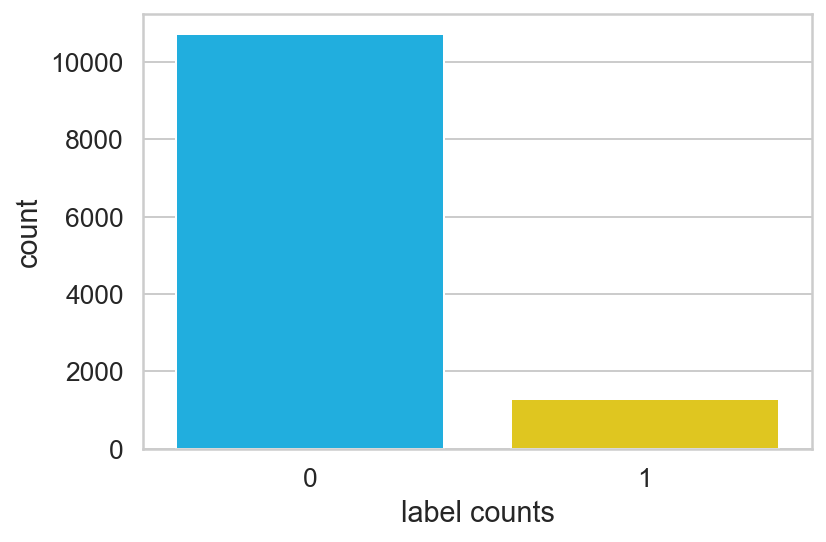

In [7]:
## 样本分布 
sns.countplot(train.label)
plt.xlabel('label counts')

In [8]:
train['text']=train['content']+' '+train['level_1']+' '+train['level_2']+' '+train['level_3']+' '+train['level_4']
train.head(5)

id            level_1  level_2           level_3  \
0   0  工业/危化品类（现场）—2016版  （二）电气安全  6、移动用电产品、电动工具及照明   
1   1  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   
2   2  工业/危化品类（现场）—2016版  （一）消防检查            2、防火检查   
3   3  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   
4   4  工业/危化品类（现场）—2016版  （一）消防检查            1、防火巡查   

                                             level_4  \
0  1、移动使用的用电产品和I类电动工具的绝缘线，必须采用三芯(单相)或四芯(三相)多股铜芯橡套软线。   
1                           3、消防设施、器材和消防安全标志是否在位、完整；   
2                           6、重点工种人员以及其他员工消防知识的掌握情况；   
3                           3、消防设施、器材和消防安全标志是否在位、完整；   
4                  4、常闭式防火门是否处于关闭状态，防火卷帘下是否堆放物品影响使用；   

                      content  label  \
0  使用移动手动电动工具,外接线绝缘皮破损,应停止使用.      0   
1                          一般      1   
2                     消防知识要加强      0   
3             消防通道有货物摆放 清理不及时      0   
4                     防火门打开状态      0   

                                                text  
0  使用移动手动电动工具,外接线绝缘皮破损,应停止使用. 工业/危化品类（现场）—2016版 （...  
1  一般 工业/危化品类（现场）—2016版 （一）消防检查 1、防火巡查 3、消防设施、器材和...  
2  消防知识要加强 工业/危化品类（现场）—2016版 （一）消防检查 2、防火检查 6、重点工...  
3  消防通道有货物摆放 清理不及时 工业/危化品类（现场）—2016版 （一）消防检查 1、防火...  
4  防火门打开状态 工业/危化品类（现场）—2016版 （一）消防检查 1、防火巡查 4、常闭式...

In [9]:
test['text']=test['content']+' '+test['level_1']+' '+test['level_2']+' '+test['level_3']+' '+test['level_4']

In [10]:
## 文本长度分布 
train['text_lens'] = train['text'].map(len)
train['text_lens'].describe()   

count    12000.000000
mean        82.433250
std         22.658626
min         45.000000
25%         68.000000
50%         77.000000
75%         94.000000
max        360.000000
Name: text_lens, dtype: float64

<AxesSubplot:ylabel='Density'>

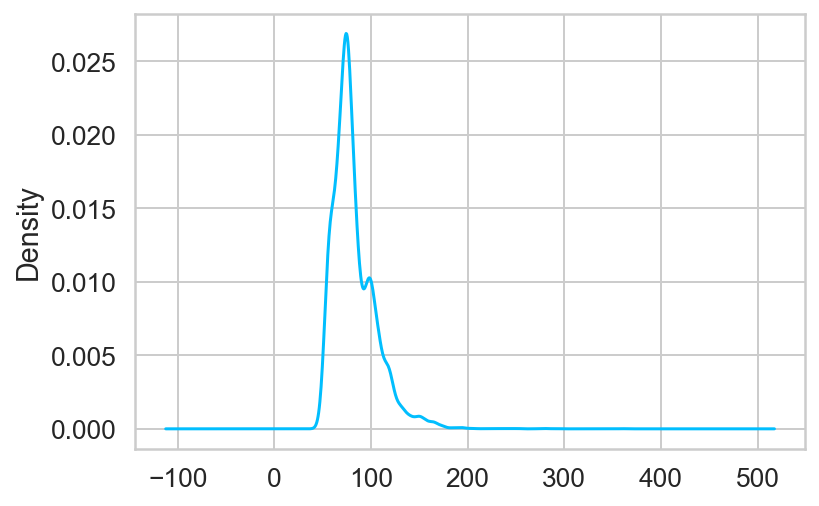

In [11]:
train['text_lens'].plot(kind='kde')

In [15]:
pretrain_model_name = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

/Users/liu_ryan/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


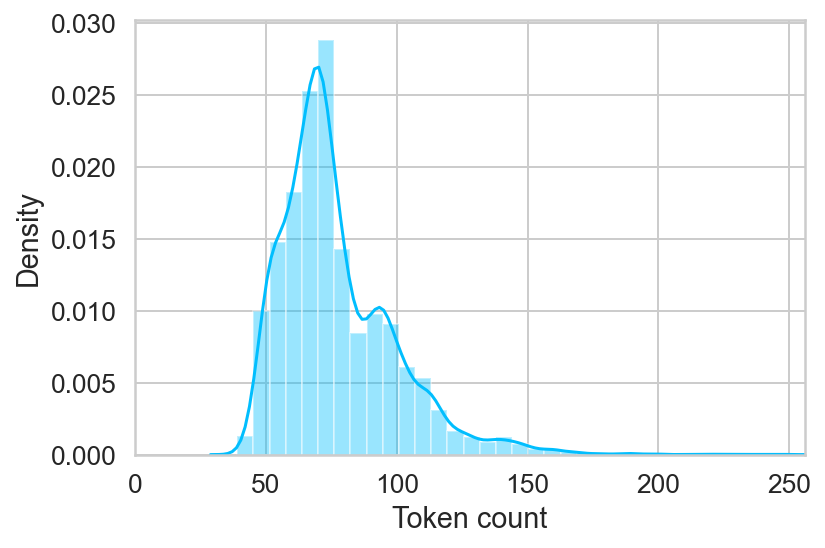

In [21]:
token_lens = []

for txt in train.text:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [22]:
## 设定 max_len = 160 可以覆盖绝大多数text
max_len = 160

In [23]:
## 构建数据集 
class EnterpriseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        '''
        item 是数据索引，迭代取第item条数据
        '''
        text = str(self.texts[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'texts':text,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['attention_mask'].flatten(),
            'labels':torch.tensor(label,dtype=torch.long)
        }
        

In [24]:
## 划分数据集
## 训练集df_train 验证集df_val 测试集df_test 
df_train,df_test = train_test_split(train,test_size=0.1,random_state = 42)
df_val,df_test = train_test_split(df_test, test_size=0.5,random_state = 42)
df_train.shape, df_val.shape, df_test.shape

((10800, 9), (600, 9), (600, 9))

In [25]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    
    ds = EnterpriseDataset(texts = df['text'].values,
                          labels = df['label'].values,
                          tokenizer = tokenizer,
                          max_len = 160)
    return DataLoader(
        ds,
        batch_size = batch_size
                     )

In [26]:
## 设置下游任务的参数
batch_size = 4
train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, batch_size)

In [27]:
next(iter(train_data_loader))

/Users/liu_ryan/opt/anaconda3/envs/py37/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'texts': ['指示标识不清楚 工业/危化品类（现场）—2016版 （一）消防检查 1、防火巡查 2、安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '发现本月有灭火器过期，已安排购买灭火器更换 商贸服务教文卫类（现场）—2016版 （一）消防检查 2、防火检查 4、灭火器材配置及有效情况。',
  '安全出口标志灯有一个有故障，已买回安装改正。 工业/危化品类（现场）—2016版 （一）消防检查 1、防火巡查 2、安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；',
  '堵了消防通道 工业/危化品类（现场）—2016版 （一）消防检查 1、防火巡查 2、安全出口、疏散通道是否畅通，安全疏散指示标志、应急照明是否完好；'],
 'input_ids': tensor([[ 101, 2900, 4850, 3403, 6399,  679, 3926, 3504, 2339,  689,  120, 1314,
          1265, 1501, 5102, 8020, 4385, 1767, 8021,  100, 8112, 4276, 8020,  671,
          8021, 3867, 7344, 3466, 3389,  122,  510, 7344, 4125, 2337, 3389,  123,
           510, 2128, 1059, 1139, 1366,  510, 4541, 3141, 6858, 6887, 3221, 1415,
          4517, 6858, 8024, 2128, 1059, 4541, 3141, 2900, 4850, 3403, 2562,  510,
          2418, 2593, 4212, 3209, 3221, 1415, 2130, 1962, 8039,  102,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 

In [28]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'labels'])

In [29]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([4, 160])
torch.Size([4, 160])
torch.Size([4])


In [30]:
bert_model = BertModel.from_pretrained(pretrain_model_name)
bert_model

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [31]:
sample = '消防设施、器材和消防安全标志是否在位、完整'
## 编码举例 
encoding = tokenizer.encode_plus(
    sample,
    max_length=32,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
encoding

{'input_ids': tensor([[ 101, 3867, 7344, 6392, 3177,  510, 1690, 3332, 1469, 3867, 7344, 2128,
         1059, 3403, 2562, 3221, 1415, 1762,  855,  510, 2130, 3146,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [33]:
print(len(encoding['input_ids'][0]))

32


In [34]:
print(len(encoding['attention_mask'][0]))

32


In [35]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '消',
 '防',
 '设',
 '施',
 '、',
 '器',
 '材',
 '和',
 '消',
 '防',
 '安',
 '全',
 '标',
 '志',
 '是',
 '否',
 '在',
 '位',
 '、',
 '完',
 '整',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']